In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np

print(tf.__version__)

2.11.0


In [6]:
DATASET_DIR: str = "/content/drive/MyDrive/Colab Notebooks/Covid19-dataset"

In [7]:
import os
for dirpath, dirnames, filenames in os.walk(DATASET_DIR):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train'.
There are 0 directories and 70 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train/Viral Pneumonia'.
There are 0 directories and 70 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train/Normal'.
There are 0 directories and 111 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train/Covid'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test/Viral Pneumonia'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test/Normal'.
There are 0 directories and 26 images in '/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test/Covid'.


In [8]:
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])).tolist() # created a list of class_names from the subdirector
class_names

['Covid', 'Normal', 'Viral Pneumonia']

Image shape: (1509, 2111, 3)


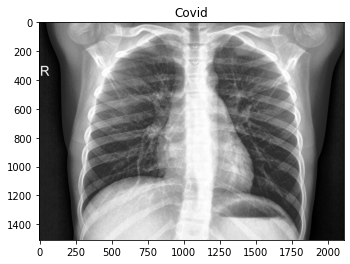

In [10]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

target_class = random.choice(class_names)
target_folder: str = "/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train/" + random.choice(class_names)

# Get a random image path
random_image = random.sample(os.listdir(target_folder), 1)

# Read in the image and plot it using matplotlib
img = mpimg.imread(target_folder + "/" + random_image[0])
plt.imshow(img)
plt.title(target_class)

print(f"Image shape: {img.shape}")

In [11]:
BATCH_SIZE: int = 1
EPOCHS: int = 15
IMAGE_SIZE = (1000, 1000)
AUGMENTATION_FACTOR: float = 0.2
LABEL_MODE: str = "categorical"
TRAIN_DIR: str = "/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train"
TEST_DIR: str = "/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test"
RANDOM_SEED: int = 42

In [12]:
print("Training data 🧠:")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode=LABEL_MODE,
    seed=RANDOM_SEED,
    shuffle=True,
)

print("Testing data 🧪:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode=LABEL_MODE,
    seed=RANDOM_SEED,
    shuffle=False,
)

Training data 🧠:
Found 251 files belonging to 3 classes.
Testing data 🧪:
Found 66 files belonging to 3 classes.


In [13]:
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, RandomHeight, RandomWidth, Dense, Rescaling
from tensorflow.keras import Sequential
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [14]:
augmentation_layer = Sequential([
    RandomFlip("horizontal", seed=RANDOM_SEED),
    RandomRotation(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomZoom(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomHeight(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomWidth(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    Rescaling(1/255.)
], name="augmentation_layer")

augmentation_layer

/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train/Normal/095.jpeg


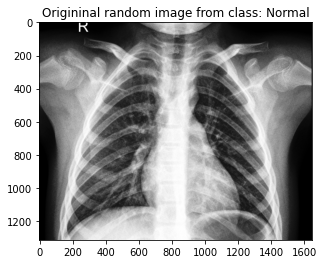

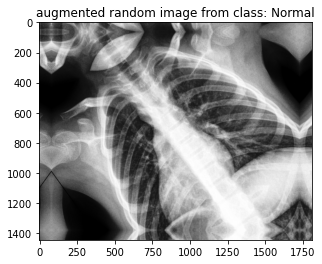

In [15]:
target_dir = "/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/train"
target_class = random.choice(class_names)
target_dir = f"{target_dir}/{target_class}"
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

print(random_image_path)
# Read in the random image
img = mpimg.imread(random_image_path)
plt.title(f"Origininal random image from class: {target_class}")
# plt.axis(False)
plt.imshow(img);

# Now lets plot our augmented random image
augmented_image = augmentation_layer(img, training=True)
plt.figure()
plt.title(f"augmented random image from class: {target_class}")
plt.imshow(augmented_image)

In [16]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False

# Input layer
input_layer = tf.keras.layers.Input(shape=IMAGE_SIZE + (3, ), name="input_layer")
x = augmentation_layer(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
x = Dense(300, activation=tf.keras.activations.relu)(x)
output_layer = Dense(len(class_names), activation=softmax, name="output_layer")(x)

model_1 = tf.keras.Model(input_layer, output_layer)

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
model_1.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [19]:
modelcheckpoint_directory_path: str = "checkpoint_weights/checkpoint.cpk"

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=modelcheckpoint_directory_path,
    monitor=f"val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", # watch the val acc metric
                                                  patience=3) # if val_accuracy decreases for 3 epochs in a row, stop training

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [20]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"

    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + \
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [21]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1000, 1000, 3)]   0         
                                                                 
 augmentation_layer (Sequent  (None, None, 3)          0         
 ial)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 300)               384300    
                                                             

In [25]:
preds_probs = model_1.predict(test_data)
preds_probs[:10]

66/66 [==============================] - 32s 478ms/step


array([[4.5914125e-01, 1.7309785e-01, 3.6776087e-01],
       [9.9966538e-01, 2.8400827e-05, 3.0627850e-04],
       [9.7909617e-01, 1.3775290e-03, 1.9526379e-02],
       [9.8211539e-01, 1.2276278e-02, 5.6083272e-03],
       [9.4344819e-01, 1.4957699e-02, 4.1594144e-02],
       [9.9566770e-01, 3.1742777e-03, 1.1580067e-03],
       [9.9001884e-01, 4.1007320e-03, 5.8804732e-03],
       [9.8582155e-01, 2.7148617e-03, 1.1463683e-02],
       [9.5205259e-01, 1.0065389e-02, 3.7882011e-02],
       [9.4634974e-01, 5.0704421e-05, 5.3599559e-02]], dtype=float32)

In [26]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.9848484848484849

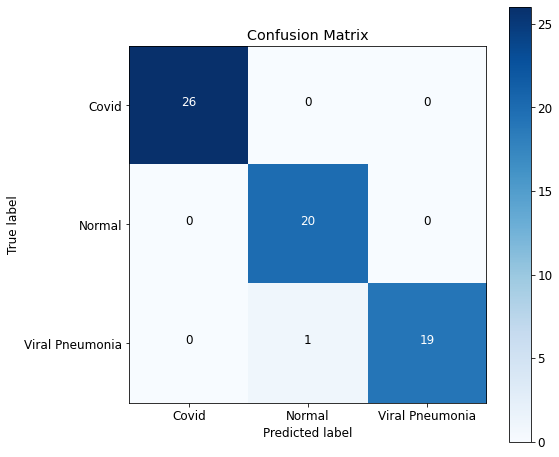

In [29]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    plt.rcParams.update({"font.size": text_size})
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / \
        cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with
    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    # colors will represent how 'correct' a class is, darker == better
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           # create enough axis slots for each class
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           # axes will labeled with class names (if they exist) or ints
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(8, 8),
                      text_size=12)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.95      1.00      0.98        20
           2       1.00      0.95      0.97        20

    accuracy                           0.98        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



In [32]:
from sklearn.metrics import classification_report

classification_report_dict = classification_report(y_labels, y_labels, output_dict=True)
    # Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

# Trun f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_names,f1-score
0,Covid,1.0
1,Normal,1.0
2,Viral Pneumonia,1.0


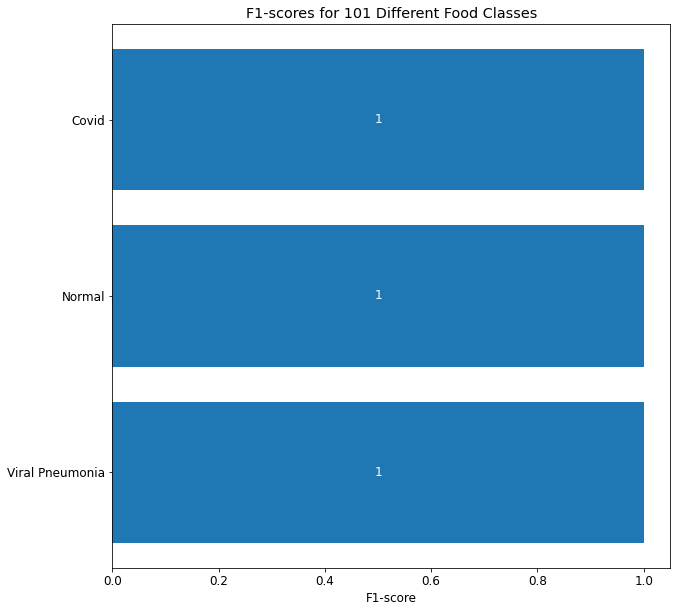

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.bar_label(scores, label_type='center', c="white")
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis();

In [34]:
def load_and_prep_image(filename):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, list(IMAGE_SIZE))
    return img/255.

In [35]:
import os
import random

def make_random_prediction(class_names, test_dir, qty: int = 3, figsize =(17, 10), fontsize: int = 12):
    plt.figure(figsize=figsize)
    for i in range(qty):
        # Choose random image(s) from random class(es)
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(test_dir + "/" + class_name))
        filepath = test_dir + "/" + class_name + "/" + filename
        
        # Load the image and make predictions
        print("filepath:", filepath)
        img = load_and_prep_image(filepath)
        print("before:", img.shape)
        img_expanded = tf.expand_dims(img, axis=0)
        print("after: ", img_expanded.shape)
        pred_prob = model_1.predict(img_expanded) # get prediction probabilities array
        pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list

        # Plot the image(s)
        plt.subplot(1, qty, i+1)
        # print(img)
        plt.imshow(img)
        if class_name == pred_class: # if predicted class matches truth class, make text green
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color, fontdict= {'fontsize': fontsize})
        plt.axis(False);

filepath: /content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test/Normal/0120.jpeg
before: (1000, 1000, 3)
after:  (1, 1000, 1000, 3)
1/1 [==============================] - 1s 1s/step
filepath: /content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test/Viral Pneumonia/0101.jpeg
before: (1000, 1000, 3)
after:  (1, 1000, 1000, 3)
1/1 [==============================] - 0s 439ms/step
filepath: /content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test/Covid/COVID-00003b.jpg
before: (1000, 1000, 3)
after:  (1, 1000, 1000, 3)
1/1 [==============================] - 0s 447ms/step


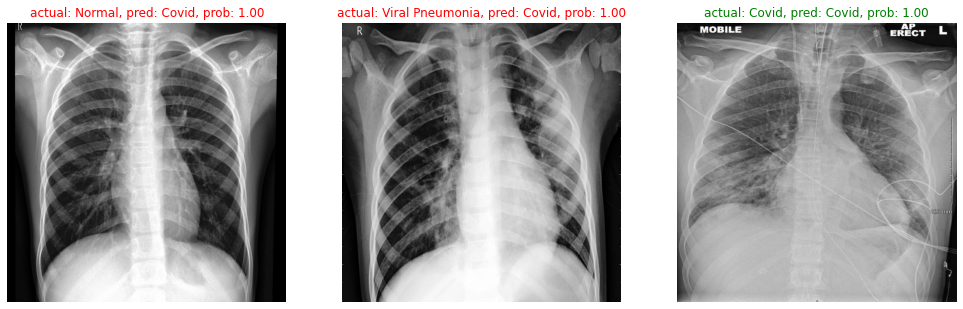

In [36]:
make_random_prediction(class_names, test_dir="/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/test")